In [1]:
import unidecode

In [2]:
unidecode.unidecode

<function unidecode.unidecode_expect_ascii(string: str, errors: str = 'ignore', replace_str: str = '?') -> str>

In [3]:
import string
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F

#### Prepare for Dataset

In [4]:
all_chars       = string.printable
n_chars         = len(all_chars)
file            = open('./linux.txt').read()
file_len        = len(file)

print('Length of file: {}'.format(file_len))
print('All possible characters: {}'.format(all_chars))
print('Number of all possible characters: {}'.format(n_chars))

Length of file: 6546665
All possible characters: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

Number of all possible characters: 100


In [5]:
# Get a random sequence of the Shakespeare dataset.
def get_random_seq():
    seq_len     = 128  # The length of an input sequence.
    start_index = random.randint(0, file_len - seq_len)
    end_index   = start_index + seq_len + 1
    return file[start_index:end_index]

# Convert the sequence to one-hot tensor.
def seq_to_onehot(seq):
    tensor = torch.zeros(len(seq), 1, n_chars) 
    # Shape of the tensor:
    #     (sequence length, batch size, classes)
    # Here we use batch size = 1 and classes = number of unique characters.
    for t, char in enumerate(seq):
        index = all_chars.index(char)
        tensor[t][0][index] = 1
    return tensor

# Convert the sequence to index tensor.
def seq_to_index(seq):
    tensor = torch.zeros(len(seq), 1)
    # Shape of the tensor: 
    #     (sequence length, batch size).
    # Here we use batch size = 1.
    for t, char in enumerate(seq):
        tensor[t] = all_chars.index(char)
    return tensor

# Sample a mini-batch including input tensor and target tensor.
def get_input_and_target():
    seq    = get_random_seq()
    input  = seq_to_onehot(seq[:-1])      # Input is represented in one-hot.
    target = seq_to_index(seq[1:]).long() # Target is represented in index.
    return input, target

#### Choose a Device

In [6]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


#### Network Definition

In [43]:
class Net(nn.Module):
    def __init__(self):
        # Initialization.
        super(Net, self).__init__()
        self.input_size  = n_chars   # Input size: Number of unique chars.
        self.hidden_size = 100      # Hidden size: 100.
        self.output_size = n_chars   # Output size: Number of unique chars.
        
        ###### To be filled ######
        ###### To be filled ######
        self.rnn_cell = nn.RNNCell(self.input_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)
        self.leaky_relu = nn.LeakyReLU()
        self.selu = nn.SELU()
    def forward(self, input, hidden):
        """ Forward function.
              input:  One-hot input. It refers to the x_t in homework write-up.
              hidden: Previous hidden state. It refers to the h_{t-1}.
            Returns (output, hidden) where output refers to y_t and 
                     hidden refers to h_t.
        """
        # Forward function.
        #hidden = torch.sigmoid(self.rnn_cell(input, hidden))
        #hidden = torch.relu(self.rnn_cell(input, hidden))
        #hidden = torch.tanh(self.rnn_cell(input, hidden))
        #hidden = self.leaky_relu(self.rnn_cell(input, hidden))
        #hidden = self.selu(self.rnn_cell(input, hidden))
        hidden = F.silu(self.rnn_cell(input, hidden))
        output = self.linear(hidden)

        return output, hidden

    def init_hidden(self):
        # Initial hidden state.
        # 1 means batch size = 1.
        return torch.zeros(1, self.hidden_size).to(device) 
    
net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

Net(
  (rnn_cell): RNNCell(100, 100)
  (linear): Linear(in_features=100, out_features=100, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.01)
  (selu): SELU()
)

#### Training Step and Evaluation Step

In [44]:
# Training step function.
def train_step(net, opt, input, target):
    """ Training step.
        net:    The network instance.
        opt:    The optimizer instance.
        input:  Input tensor.  Shape: [seq_len, 1, n_chars].
        target: Target tensor. Shape: [seq_len, 1].
    """
    seq_len = input.shape[0]    # Get the sequence length of current input.
    hidden = net.init_hidden()  # Initial hidden state.
    net.zero_grad()             # Clear the gradient.
    loss = 0                    # Initial loss.

    for t in range(seq_len):    # For each one in the input sequence.
        output, hidden = net(input[t], hidden)
        loss += loss_func(output, target[t])

    loss.backward()             # Backward. 
    opt.step()                  # Update the weights.

    return loss / seq_len       # Return the average loss w.r.t sequence length.

In [45]:
# Evaluation step function.
def eval_step(net, init_seq='W', predicted_len=100):
    # Initialize the hidden state, input and the predicted sequence.
    hidden        = net.init_hidden()
    init_input    = seq_to_onehot(init_seq).to(device)
    predicted_seq = init_seq

    # Use initial string to "build up" hidden state.
    for t in range(len(init_seq) - 1):
        output, hidden = net(init_input[t], hidden)
        
    # Set current input as the last character of the initial string.
    input = init_input[-1]
    
    # Predict more characters after the initial string.
    for t in range(predicted_len):
        # Get the current output and hidden state.
        output, hidden = net(input, hidden)
        
        # Sample from the output as a multinomial distribution.
        predicted_index = torch.multinomial(output.view(-1).exp(), 1)[0]
        
        # Add predicted character to the sequence and use it as next input.
        predicted_char  = all_chars[predicted_index]
        predicted_seq  += predicted_char
        
        # Use the predicted character to generate the input of next round.
        input = seq_to_onehot(predicted_char)[0].to(device)

    return predicted_seq

#### Training Procedure

In [46]:
# Number of iterations.
# NOTE: You may reduce the number of training iterations if the training takes long.
iters       = 20000  # Number of training iterations.
print_iters = 100    # Number of iterations for each log printing.

# The loss variables.
all_losses = []
loss_sum   = 0

# Initialize the optimizer and the loss function.
opt       = torch.optim.Adam(net.parameters(), lr=0.005)
loss_func = nn.CrossEntropyLoss()

# Training procedure.
for i in range(iters):
    input, target = get_input_and_target()            # Fetch input and target.
    input, target = input.to(device), target.to(device) # Move to GPU memory.
    loss      = train_step(net, opt, input, target)   # Calculate the loss.
    #loss_sum += loss                                  # Accumulate the loss.
    loss_sum += loss.item()
    # Print the log.
    if i % print_iters == print_iters - 1:
        print('iter:{}/{} loss:{}'.format(i, iters, loss_sum / print_iters))
        print('generated sequence: {}\n'.format(eval_step(net)))
              
        # Track the loss.
        all_losses.append(loss_sum / print_iters)
        loss_sum = 0

iter:99/20000 loss:3.709166054725647
generated sequence: W7y/trga	eis c;ettU_ot-	i_eNenNc	nce  wOrFohos_nyks_IshlSh een-ct; )enkai(iP6a1},E_"ucto1itlstrzsems(

iter:199/20000 loss:3.23473717212677
generated sequence: W|tgduloret _pora,elicoc' lokkav.ve_f_saeiot fhingelecicsttpsceaer z dachtlyelrafderbturri oht ponp_p

iter:299/20000 loss:2.937884125709534
generated sequence: W= ros (atp);
	it/
		
		ihpbat pinl spe>.edath) n* );
	tngtinsid_inca_t_rini	  is sintranl-ons ->nnd


iter:399/20000 loss:2.786874885559082
generated sequence: Wlont_nlinc sho:
 * mxsc s p"_seapr[<%ik caann&n_bola f stax T*{
		 moce(deale au.ifntase af = CN! PA

iter:499/20000 loss:2.652180631160736
generated sequence: WANTEAD!_OTst_kuret(acjees whib idedst tite = ithosk, ans_fer anfeece;

}

	ef hr tosk| flifid icksif

iter:599/20000 loss:2.5590623664855956
generated sequence: WCE_RAAG_NAPEIOBUPRG_Bz_pr, sasted_cugeex (	ppa_g-ore_per_ratonf inspuctercphar DP * = weifme)
{
	if 

iter:699/20000 loss:2.5002519512176

#### Training Loss Curve

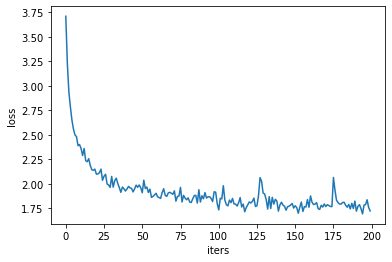

In [47]:
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(all_losses)
plt.show()

#### Evaluation: A Sample of Generated Sequence

In [48]:
print(eval_step(net, predicted_len=600))

WCO_EXF_COMIYNEX64: vALK_MAP])
{
	wait.flon., :%s, moduleroot than kthread_perf_worker)
		return allog_rq);
	}

	return lise_regervage cquare to pay called
 * samemore task.
 ** .local lock.
	 */
		if (user this return'thed to sure alldat ths on olem EKUSS_dumblens;
	int acsize_trace_info->save(mem_inomk(th_wake_err_ret rek_rtp);

	len(0644lst_heace,
		 */
		}
	}
	if (!camploreize	= (!must(&mamk_lock_reso);
	entry_irq_wake_lep_t)
punstate.\09%1\nd->commatt_wes_der->perce_lock)
		peck).
 */
	opsthat artory_field		filter */
	if (!v)
	/*
	 */
		currinline *enttruend to pansees the clock time ent  
